In [4]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sys
# import sweetviz as sv
from importlib import reload
import matplotlib.pyplot as plt

np.warnings = warnings

ROOT_DIR = Path('../..')
sys.path.append(os.path.abspath(os.path.join('../src')))
sys.path.append(os.path.abspath(os.path.join('..')))

import src.model_evaluation as me
reload(me)

<module 'src.model_evaluation' from '/home/labadmin/work/data-science-capstone-project/Kha Huynh/src/model_evaluation.py'>

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# evaluation metrics
from tensorflow.keras.utils import to_categorical
from keras.utils import to_categorical

import tensorflow as tf

2023-10-21 23:49:52.808498: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-21 23:49:52.809726: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-21 23:49:52.834096: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-21 23:49:52.834806: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-21 23:49:53.296879: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

# Data Preparation - Train val test split

In [5]:
# t0_df = pd.read_csv(df_final)
path_df = ROOT_DIR / 'data/full_data_lstm/t8_top20_sequence.csv'
df_data = pd.read_csv(path_df)# t0_df

admission = df_data[['SUBJECT_ID', 'HADM_ID', 'IS_SEPSIS']].drop_duplicates(["SUBJECT_ID", "HADM_ID"])

def df_split(X, Y, test_size):
    x_train, x_test, y_train, y_test = train_test_split(
        X,  # dropping the target column for X values
        Y,
        test_size=test_size,  # this means 20% test set
        stratify=Y,  # stratify by the target variable
        random_state=42  # to ensure reproducibility
        )
    return x_train, x_test, y_train, y_test

def create_data_df(data_df):
    x_train_df = df_data.merge(data_df[['SUBJECT_ID', 'HADM_ID']])
    x_train_df['count'] = x_train_df.groupby(['SUBJECT_ID', 'HADM_ID'])['HADM_ID'].transform('count')
    x_train_count = x_train_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['count']
    y_train_df = x_train_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['IS_SEPSIS']
    return x_train_df, x_train_count, y_train_df

x_train_df, x_test_df, y_train_df, _ = df_split(admission.drop('IS_SEPSIS', axis=1),  # dropping the target column for X values
                                                admission['IS_SEPSIS'],
                                                test_size=0.2,
                                                )

x_train_df, x_train_count, y_train_df = create_data_df(x_train_df)
x_test_df, x_test_count, y_test_df = create_data_df(x_test_df)

In [4]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median', missing_values=np.nan)

train_gendernum = x_train_df.GENDER_NUM.values #take out the column doesn't need to scale
test_gendernum = x_test_df.GENDER_NUM.values

# impute X
x_train = imputer.fit_transform(x_train_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))
x_test = imputer.transform(x_test_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))

In [5]:
# Feature scaling - Standardisation
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train) #scale X
x_test = scaler.transform(x_test)

x_train = np.column_stack((x_train, train_gendernum)) #merge the columns doesn't need to scale back to X
x_test = np.column_stack((x_test, test_gendernum))

In [6]:
def ts_to_secs(X, X_count, Y):
    secs_data = tf.RaggedTensor.from_row_lengths(X, X_count)
    mask = tf.math.is_finite(secs_data.values)
    mask = tf.RaggedTensor.from_row_lengths(mask, X_count)

    # act_secs_labels = Y.values
    # act_secs_labels = np.array(act_secs_labels)
    act_secs_labels = to_categorical(Y)
    return secs_data, act_secs_labels, mask


In [7]:
def data_preparation():
  train_data, act_train, mask_train = ts_to_secs(x_train, x_train_count, y_train_df)
  test_data, act_test, mask_test = ts_to_secs(x_test, x_test_count, y_test_df)

  # Here we add an extra dimension to the datasets just to be ready for using with Convolution2D
  print("[INFO] -- Shape of Training Sections:")
  print(train_data.bounding_shape())
  print("[INFO] -- Shape of Test Sections:")
  print(test_data.bounding_shape())

  return train_data, act_train, test_data, act_test

In [8]:
x_train, y_train, x_test, y_test = data_preparation()

[INFO] -- Shape of Training Sections:
tf.Tensor([36972    13    43], shape=(3,), dtype=int64)
[INFO] -- Shape of Test Sections:
tf.Tensor([9244   13   43], shape=(3,), dtype=int64)


# Model Definition

In [9]:
import model_evaluation as me
reload(me)

me.get_class_weights(y_train_df)

# sample_weights = mask_train
sample_weights = me.compute_sample_weights(y_train[:,1].astype(int))
# sample_weights = compute_sample_weights(y_train.astype(int))

# sample_weights_test = mask_test
sample_weights_test = me.compute_sample_weights(y_test[:,1].astype(int))
# sample_weights_test = compute_sample_weights(y_test.astype(int))

In [10]:
import keras

METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
]

m_hist = []
models = []

# Simple LSTM

In [11]:
from keras.optimizers import schedules
from keras.callbacks import LearningRateScheduler
import math

init_lr = 0.001

def scheduler(epoch):
  return init_lr * tf.math.exp(-0.1 * epoch)
lr_scheduler = LearningRateScheduler(scheduler)

In [12]:
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Input, GRU, Masking
from keras.models import Sequential, Model
from sklearn.model_selection import  train_test_split
import time
import keras
import numpy as np
from keras.models import Sequential

def GRU_model():
    feat_no = x_train[0][0].shape[0]
    d = 0.25
    model=Sequential()
    model.add(Input(shape=[None, feat_no], dtype=tf.float32, ragged=True))
    model.add(GRU(128))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))

    return model
model = GRU_model()
models.append(model)

In [13]:
def GRU_model():
    feat_no = x_train[0][0].shape[0]
    d = 0.25
    model=Sequential()
    model.add(Input(shape=[None, feat_no], dtype=tf.float32, ragged=True))
    model.add(GRU(256))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))

    return model
model = GRU_model()
models.append(model)

In [14]:
def GRU_model():
    feat_no = x_train[0][0].shape[0]
    d = 0.25
    model=Sequential()
    model.add(Input(shape=[None, feat_no], dtype=tf.float32, ragged=True))
    model.add(GRU(64))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))

    return model
model = GRU_model()
models.append(model)

In [15]:
from sklearn.model_selection import StratifiedKFold
k = 5
fold_size = x_train.shape[0] // k
num_epochs = 20

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
for i, model in enumerate(models):
  print(f"----------------Start model {i}---------------------")
  model.summary()

  checkpointer = ModelCheckpoint(filepath = f'models/weights_best_struct_gru1_{i}.hdf5', save_best_only = True, monitor='val_accuracy', mode='max')
  early_stop = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=5, restore_best_weights=True)
  callbacks_list = [lr_scheduler, early_stop, checkpointer]
  acc, val_acc, auc, val_auc, loss, val_loss= [], [], [], [], [], []
  # Loop through the k folds
  for j, (train_index, val_index) in enumerate(skf.split(x_train, y_train.argmax(1))):
    print(f'---------------------K={j}-------------------------------')
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=init_lr), loss='binary_crossentropy', metrics = METRICS)

    x_train_kf, x_val_kf = tf.gather(x_train, train_index), tf.gather(x_train, val_index)
    y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]

    sample_weights = me.compute_sample_weights(y_train_kf[:,1].astype(int))

    # Train the model
    m = model.fit(x_train_kf,y_train_kf,
              sample_weight=sample_weights,
              epochs=num_epochs, batch_size=64, verbose=1,
              validation_data=(x_val_kf, y_val_kf),
              callbacks=callbacks_list)
    m_hist.append(m)

----------------Start model 0---------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               66432     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 66690 (260.51 KB)
Trainable params: 66690 (260.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
---------------------K=0-------------------------------
Epoch 1/20
463/463 [==============================] - 7s 11ms/step - loss: 0.5537 - accuracy: 0.7067 - auc: 0.7613 - val_loss: 0.5026 - val_accuracy: 0.7779 - val_auc: 0.8407 

/home/labadmin/work/data-science-capstone-project/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 4s 9ms/step - loss: 0.5105 - accuracy: 0.7632 - auc: 0.8252 - val_loss: 0.5350 - val_accuracy: 0.7413 - val_auc: 0.8084 - lr: 9.0484e-04
Epoch 3/20
463/463 [==============================] - 4s 9ms/step - loss: 0.4991 - accuracy: 0.7648 - auc: 0.8296 - val_loss: 0.4893 - val_accuracy: 0.7750 - val_auc: 0.8457 - lr: 8.1873e-04
Epoch 4/20
463/463 [==============================] - 4s 9ms/step - loss: 0.4885 - accuracy: 0.7702 - auc: 0.8417 - val_loss: 0.5024 - val_accuracy: 0.7718 - val_auc: 0.8363 - lr: 7.4082e-04
Epoch 5/20
463/463 [==============================] - 4s 9ms/step - loss: 0.4785 - accuracy: 0.7785 - auc: 0.8502 - val_loss: 0.5063 - val_accuracy: 0.7690 - val_auc: 0.8353 - lr: 6.7032e-04
Epoch 6/20
463/463 [==============================] - 4s 9ms/step - loss: 0.4688 - accuracy: 0.7835 - auc: 0.8549 - val_loss: 0.4921 - val_accuracy: 0.7721 - val_auc: 0.8435 - lr: 6.0653e-04
---------------------K=1-------------------------------


/home/labadmin/work/data-science-capstone-project/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 5s 11ms/step - loss: 0.5020 - accuracy: 0.7684 - auc: 0.8325 - val_loss: 0.4863 - val_accuracy: 0.7755 - val_auc: 0.8464 - lr: 9.0484e-04
Epoch 3/20
463/463 [==============================] - 5s 10ms/step - loss: 0.4925 - accuracy: 0.7729 - auc: 0.8390 - val_loss: 0.5112 - val_accuracy: 0.7669 - val_auc: 0.8309 - lr: 8.1873e-04
Epoch 4/20
463/463 [==============================] - 5s 11ms/step - loss: 0.4817 - accuracy: 0.7784 - auc: 0.8474 - val_loss: 0.4850 - val_accuracy: 0.7813 - val_auc: 0.8484 - lr: 7.4082e-04
Epoch 5/20
463/463 [==============================] - 5s 10ms/step - loss: 0.4708 - accuracy: 0.7831 - auc: 0.8552 - val_loss: 0.4880 - val_accuracy: 0.7784 - val_auc: 0.8460 - lr: 6.7032e-04
Epoch 6/20
463/463 [==============================] - 5s 10ms/step - loss: 0.4600 - accuracy: 0.7843 - auc: 0.8584 - val_loss: 0.4989 - val_accuracy: 0.7707 - val_auc: 0.8397 - lr: 6.0653e-04
Epoch 7/20
463/463 [==============================]

/home/labadmin/work/data-science-capstone-project/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 4s 9ms/step - loss: 0.4043 - accuracy: 0.8200 - auc: 0.8960 - val_loss: 0.4173 - val_accuracy: 0.8177 - val_auc: 0.8909 - lr: 8.1873e-04
Epoch 4/20
463/463 [==============================] - 4s 9ms/step - loss: 0.3920 - accuracy: 0.8251 - auc: 0.9009 - val_loss: 0.3905 - val_accuracy: 0.8335 - val_auc: 0.9050 - lr: 7.4082e-04
Epoch 5/20
463/463 [==============================] - 4s 9ms/step - loss: 0.3812 - accuracy: 0.8315 - auc: 0.9063 - val_loss: 0.4081 - val_accuracy: 0.8228 - val_auc: 0.8959 - lr: 6.7032e-04
Epoch 6/20
463/463 [==============================] - 4s 9ms/step - loss: 0.3713 - accuracy: 0.8372 - auc: 0.9124 - val_loss: 0.3761 - val_accuracy: 0.8373 - val_auc: 0.9120 - lr: 6.0653e-04
Epoch 7/20
463/463 [==============================] - 4s 9ms/step - loss: 0.3601 - accuracy: 0.8432 - auc: 0.9186 - val_loss: 0.4056 - val_accuracy: 0.8259 - val_auc: 0.8981 - lr: 5.4881e-04
Epoch 8/20
463/463 [==============================] - 4s

/home/labadmin/work/data-science-capstone-project/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 4s 10ms/step - loss: 0.3682 - accuracy: 0.8371 - auc: 0.9132 - val_loss: 0.3657 - val_accuracy: 0.8375 - val_auc: 0.9162 - lr: 8.1873e-04
Epoch 4/20
463/463 [==============================] - 4s 10ms/step - loss: 0.3585 - accuracy: 0.8443 - auc: 0.9193 - val_loss: 0.3780 - val_accuracy: 0.8331 - val_auc: 0.9108 - lr: 7.4082e-04
Epoch 5/20
463/463 [==============================] - 4s 10ms/step - loss: 0.3473 - accuracy: 0.8499 - auc: 0.9245 - val_loss: 0.3826 - val_accuracy: 0.8316 - val_auc: 0.9094 - lr: 6.7032e-04
Epoch 6/20
463/463 [==============================] - 5s 10ms/step - loss: 0.3388 - accuracy: 0.8543 - auc: 0.9274 - val_loss: 0.3561 - val_accuracy: 0.8453 - val_auc: 0.9216 - lr: 6.0653e-04
Epoch 7/20
463/463 [==============================] - 4s 10ms/step - loss: 0.3297 - accuracy: 0.8557 - auc: 0.9303 - val_loss: 0.3759 - val_accuracy: 0.8377 - val_auc: 0.9133 - lr: 5.4881e-04
Epoch 8/20
463/463 [==============================]

/home/labadmin/work/data-science-capstone-project/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 4s 9ms/step - loss: 0.3382 - accuracy: 0.8573 - auc: 0.9292 - val_loss: 0.3299 - val_accuracy: 0.8634 - val_auc: 0.9339 - lr: 9.0484e-04
Epoch 3/20
463/463 [==============================] - 4s 8ms/step - loss: 0.3269 - accuracy: 0.8585 - auc: 0.9310 - val_loss: 0.3013 - val_accuracy: 0.8727 - val_auc: 0.9450 - lr: 8.1873e-04
Epoch 4/20
463/463 [==============================] - 4s 8ms/step - loss: 0.3181 - accuracy: 0.8653 - auc: 0.9381 - val_loss: 0.3322 - val_accuracy: 0.8610 - val_auc: 0.9327 - lr: 7.4082e-04
Epoch 5/20
463/463 [==============================] - 4s 8ms/step - loss: 0.3073 - accuracy: 0.8721 - auc: 0.9424 - val_loss: 0.3103 - val_accuracy: 0.8742 - val_auc: 0.9419 - lr: 6.7032e-04
Epoch 6/20
463/463 [==============================] - 4s 8ms/step - loss: 0.2920 - accuracy: 0.8773 - auc: 0.9467 - val_loss: 0.3091 - val_accuracy: 0.8754 - val_auc: 0.9424 - lr: 6.0653e-04
Epoch 7/20
463/463 [==============================] - 4s

/home/labadmin/work/data-science-capstone-project/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 7s 16ms/step - loss: 0.5096 - accuracy: 0.7605 - auc: 0.8242 - val_loss: 0.5558 - val_accuracy: 0.7371 - val_auc: 0.7951 - lr: 9.0484e-04
Epoch 3/20
463/463 [==============================] - 7s 16ms/step - loss: 0.4968 - accuracy: 0.7662 - auc: 0.8349 - val_loss: 0.5126 - val_accuracy: 0.7552 - val_auc: 0.8261 - lr: 8.1873e-04
Epoch 4/20
463/463 [==============================] - 7s 16ms/step - loss: 0.4830 - accuracy: 0.7734 - auc: 0.8434 - val_loss: 0.4813 - val_accuracy: 0.7784 - val_auc: 0.8508 - lr: 7.4082e-04
Epoch 5/20
463/463 [==============================] - 7s 16ms/step - loss: 0.4710 - accuracy: 0.7823 - auc: 0.8543 - val_loss: 0.4645 - val_accuracy: 0.7902 - val_auc: 0.8617 - lr: 6.7032e-04
Epoch 6/20
463/463 [==============================] - 7s 15ms/step - loss: 0.4614 - accuracy: 0.7860 - auc: 0.8616 - val_loss: 0.4687 - val_accuracy: 0.7826 - val_auc: 0.8589 - lr: 6.0653e-04
Epoch 7/20
463/463 [==============================]

/home/labadmin/work/data-science-capstone-project/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 8s 17ms/step - loss: 0.3994 - accuracy: 0.8241 - auc: 0.8986 - val_loss: 0.3679 - val_accuracy: 0.8405 - val_auc: 0.9165 - lr: 9.0484e-04
Epoch 3/20
463/463 [==============================] - 8s 17ms/step - loss: 0.3815 - accuracy: 0.8345 - auc: 0.9081 - val_loss: 0.3897 - val_accuracy: 0.8256 - val_auc: 0.9053 - lr: 8.1873e-04
Epoch 4/20
463/463 [==============================] - 8s 17ms/step - loss: 0.3619 - accuracy: 0.8452 - auc: 0.9185 - val_loss: 0.3985 - val_accuracy: 0.8302 - val_auc: 0.9021 - lr: 7.4082e-04
Epoch 5/20
463/463 [==============================] - 8s 17ms/step - loss: 0.3545 - accuracy: 0.8476 - auc: 0.9216 - val_loss: 0.3622 - val_accuracy: 0.8442 - val_auc: 0.9187 - lr: 6.7032e-04
Epoch 6/20
463/463 [==============================] - 8s 17ms/step - loss: 0.3370 - accuracy: 0.8580 - auc: 0.9298 - val_loss: 0.3600 - val_accuracy: 0.8526 - val_auc: 0.9210 - lr: 6.0653e-04
Epoch 7/20
463/463 [==============================]

/home/labadmin/work/data-science-capstone-project/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 7s 15ms/step - loss: 0.2964 - accuracy: 0.8793 - auc: 0.9476 - val_loss: 0.2527 - val_accuracy: 0.9013 - val_auc: 0.9638 - lr: 9.0484e-04
Epoch 3/20
463/463 [==============================] - 7s 15ms/step - loss: 0.2759 - accuracy: 0.8866 - auc: 0.9545 - val_loss: 0.2618 - val_accuracy: 0.8952 - val_auc: 0.9588 - lr: 8.1873e-04
Epoch 4/20
463/463 [==============================] - 7s 15ms/step - loss: 0.2678 - accuracy: 0.8917 - auc: 0.9579 - val_loss: 0.3181 - val_accuracy: 0.8698 - val_auc: 0.9389 - lr: 7.4082e-04
Epoch 5/20
463/463 [==============================] - 7s 15ms/step - loss: 0.2556 - accuracy: 0.8972 - auc: 0.9607 - val_loss: 0.2617 - val_accuracy: 0.8988 - val_auc: 0.9594 - lr: 6.7032e-04
Epoch 6/20
463/463 [==============================] - 7s 15ms/step - loss: 0.2500 - accuracy: 0.9000 - auc: 0.9636 - val_loss: 0.2590 - val_accuracy: 0.8980 - val_auc: 0.9597 - lr: 6.0653e-04
Epoch 7/20
463/463 [==============================]

/home/labadmin/work/data-science-capstone-project/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 7s 16ms/step - loss: 0.2563 - accuracy: 0.8988 - auc: 0.9619 - val_loss: 0.2721 - val_accuracy: 0.8857 - val_auc: 0.9553 - lr: 7.4082e-04
Epoch 5/20
463/463 [==============================] - 7s 15ms/step - loss: 0.2437 - accuracy: 0.9017 - auc: 0.9651 - val_loss: 0.2561 - val_accuracy: 0.9024 - val_auc: 0.9610 - lr: 6.7032e-04
Epoch 6/20
463/463 [==============================] - 7s 15ms/step - loss: 0.2376 - accuracy: 0.9067 - auc: 0.9680 - val_loss: 0.2345 - val_accuracy: 0.9066 - val_auc: 0.9674 - lr: 6.0653e-04
Epoch 7/20
463/463 [==============================] - 7s 15ms/step - loss: 0.2248 - accuracy: 0.9125 - auc: 0.9718 - val_loss: 0.2618 - val_accuracy: 0.8965 - val_auc: 0.9589 - lr: 5.4881e-04
Epoch 8/20
463/463 [==============================] - 7s 15ms/step - loss: 0.2124 - accuracy: 0.9183 - auc: 0.9748 - val_loss: 0.2535 - val_accuracy: 0.9008 - val_auc: 0.9616 - lr: 4.9659e-04
Epoch 9/20
463/463 [==============================]

/home/labadmin/work/data-science-capstone-project/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 7s 15ms/step - loss: 0.2420 - accuracy: 0.9027 - auc: 0.9657 - val_loss: 0.2224 - val_accuracy: 0.9103 - val_auc: 0.9710 - lr: 9.0484e-04
Epoch 3/20
463/463 [==============================] - 7s 15ms/step - loss: 0.2229 - accuracy: 0.9141 - auc: 0.9718 - val_loss: 0.2106 - val_accuracy: 0.9172 - val_auc: 0.9744 - lr: 8.1873e-04
Epoch 4/20
463/463 [==============================] - 7s 15ms/step - loss: 0.2077 - accuracy: 0.9176 - auc: 0.9747 - val_loss: 0.1945 - val_accuracy: 0.9248 - val_auc: 0.9786 - lr: 7.4082e-04
Epoch 5/20
463/463 [==============================] - 7s 15ms/step - loss: 0.2038 - accuracy: 0.9222 - auc: 0.9771 - val_loss: 0.1974 - val_accuracy: 0.9205 - val_auc: 0.9770 - lr: 6.7032e-04
Epoch 6/20
463/463 [==============================] - 7s 15ms/step - loss: 0.1963 - accuracy: 0.9225 - auc: 0.9777 - val_loss: 0.1895 - val_accuracy: 0.9276 - val_auc: 0.9792 - lr: 6.0653e-04
Epoch 7/20
463/463 [==============================]

/home/labadmin/work/data-science-capstone-project/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 2s 5ms/step - loss: 0.5180 - accuracy: 0.7569 - auc: 0.8121 - val_loss: 0.5175 - val_accuracy: 0.7631 - val_auc: 0.8260 - lr: 9.0484e-04
Epoch 3/20
463/463 [==============================] - 2s 5ms/step - loss: 0.5021 - accuracy: 0.7655 - auc: 0.8292 - val_loss: 0.4957 - val_accuracy: 0.7824 - val_auc: 0.8431 - lr: 8.1873e-04
Epoch 4/20
463/463 [==============================] - 2s 5ms/step - loss: 0.4947 - accuracy: 0.7714 - auc: 0.8372 - val_loss: 0.5187 - val_accuracy: 0.7640 - val_auc: 0.8250 - lr: 7.4082e-04
Epoch 5/20
463/463 [==============================] - 2s 5ms/step - loss: 0.4828 - accuracy: 0.7820 - auc: 0.8480 - val_loss: 0.5199 - val_accuracy: 0.7592 - val_auc: 0.8227 - lr: 6.7032e-04
Epoch 6/20
463/463 [==============================] - 2s 5ms/step - loss: 0.4768 - accuracy: 0.7809 - auc: 0.8493 - val_loss: 0.4685 - val_accuracy: 0.7956 - val_auc: 0.8606 - lr: 6.0653e-04
Epoch 7/20
463/463 [==============================] - 2s

/home/labadmin/work/data-science-capstone-project/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 2s 5ms/step - loss: 0.4747 - accuracy: 0.7843 - auc: 0.8523 - val_loss: 0.4711 - val_accuracy: 0.7859 - val_auc: 0.8572 - lr: 9.0484e-04
Epoch 3/20
463/463 [==============================] - 3s 6ms/step - loss: 0.4696 - accuracy: 0.7895 - auc: 0.8576 - val_loss: 0.4744 - val_accuracy: 0.7855 - val_auc: 0.8550 - lr: 8.1873e-04
Epoch 4/20
463/463 [==============================] - 3s 6ms/step - loss: 0.4608 - accuracy: 0.7901 - auc: 0.8613 - val_loss: 0.4892 - val_accuracy: 0.7746 - val_auc: 0.8448 - lr: 7.4082e-04
Epoch 5/20
463/463 [==============================] - 3s 6ms/step - loss: 0.4528 - accuracy: 0.7959 - auc: 0.8669 - val_loss: 0.4422 - val_accuracy: 0.8045 - val_auc: 0.8753 - lr: 6.7032e-04
Epoch 6/20
463/463 [==============================] - 3s 6ms/step - loss: 0.4460 - accuracy: 0.7995 - auc: 0.8717 - val_loss: 0.4500 - val_accuracy: 0.7994 - val_auc: 0.8714 - lr: 6.0653e-04
Epoch 7/20
463/463 [==============================] - 3s

/home/labadmin/work/data-science-capstone-project/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 2s 5ms/step - loss: 0.4343 - accuracy: 0.8047 - auc: 0.8787 - val_loss: 0.4335 - val_accuracy: 0.8051 - val_auc: 0.8810 - lr: 8.1873e-04
Epoch 4/20
463/463 [==============================] - 2s 5ms/step - loss: 0.4239 - accuracy: 0.8128 - auc: 0.8849 - val_loss: 0.4300 - val_accuracy: 0.8073 - val_auc: 0.8831 - lr: 7.4082e-04
Epoch 5/20
463/463 [==============================] - 2s 5ms/step - loss: 0.4145 - accuracy: 0.8162 - auc: 0.8889 - val_loss: 0.4070 - val_accuracy: 0.8207 - val_auc: 0.8962 - lr: 6.7032e-04
Epoch 6/20
463/463 [==============================] - 2s 5ms/step - loss: 0.4091 - accuracy: 0.8171 - auc: 0.8919 - val_loss: 0.4274 - val_accuracy: 0.8088 - val_auc: 0.8850 - lr: 6.0653e-04
Epoch 7/20
463/463 [==============================] - 2s 5ms/step - loss: 0.4046 - accuracy: 0.8220 - auc: 0.8957 - val_loss: 0.4399 - val_accuracy: 0.8025 - val_auc: 0.8786 - lr: 5.4881e-04
Epoch 8/20
463/463 [==============================] - 2s

/home/labadmin/work/data-science-capstone-project/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 2s 5ms/step - loss: 0.4185 - accuracy: 0.8122 - auc: 0.8863 - val_loss: 0.4197 - val_accuracy: 0.8120 - val_auc: 0.8885 - lr: 9.0484e-04
Epoch 3/20
463/463 [==============================] - 2s 5ms/step - loss: 0.4122 - accuracy: 0.8156 - auc: 0.8900 - val_loss: 0.3943 - val_accuracy: 0.8240 - val_auc: 0.9031 - lr: 8.1873e-04
Epoch 4/20
463/463 [==============================] - 2s 5ms/step - loss: 0.4041 - accuracy: 0.8217 - auc: 0.8962 - val_loss: 0.3865 - val_accuracy: 0.8322 - val_auc: 0.9067 - lr: 7.4082e-04
Epoch 5/20
463/463 [==============================] - 2s 5ms/step - loss: 0.3946 - accuracy: 0.8261 - auc: 0.9010 - val_loss: 0.3878 - val_accuracy: 0.8355 - val_auc: 0.9066 - lr: 6.7032e-04
Epoch 6/20
463/463 [==============================] - 2s 5ms/step - loss: 0.3891 - accuracy: 0.8293 - auc: 0.9039 - val_loss: 0.4222 - val_accuracy: 0.8164 - val_auc: 0.8891 - lr: 6.0653e-04
Epoch 7/20
463/463 [==============================] - 2s

In [16]:
reload(me)

chart_types = ['accuracy', 'val_accuracy', 'auc', 'val_auc', 'loss', 'val_loss']
mean_history = me.cal_model_mean(m_hist, k, chart_types)

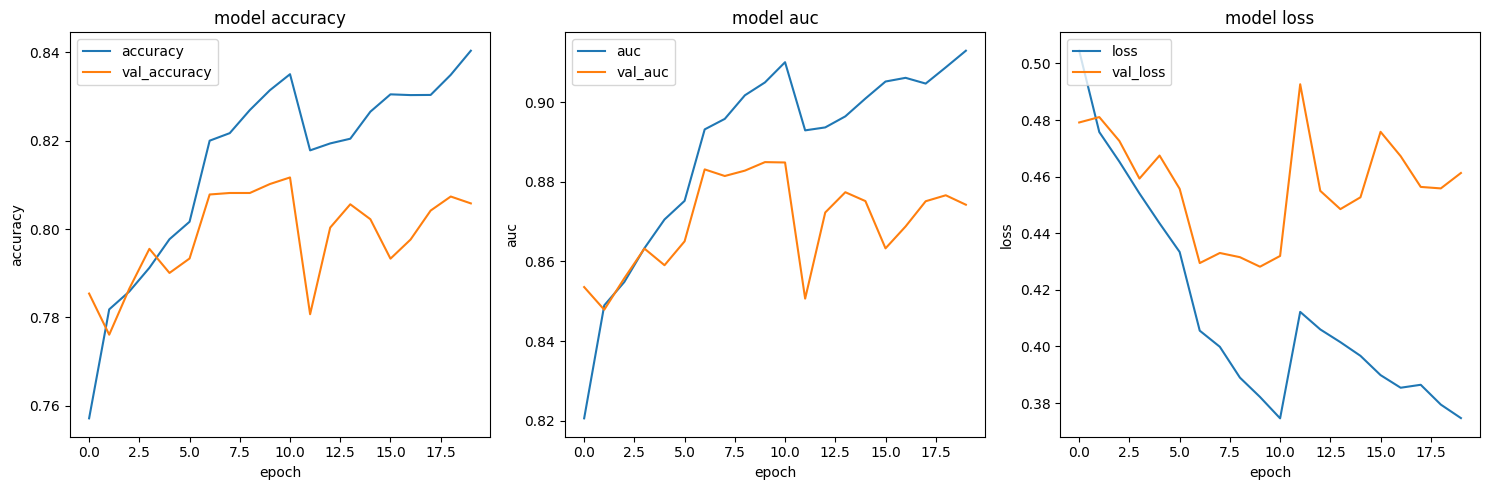

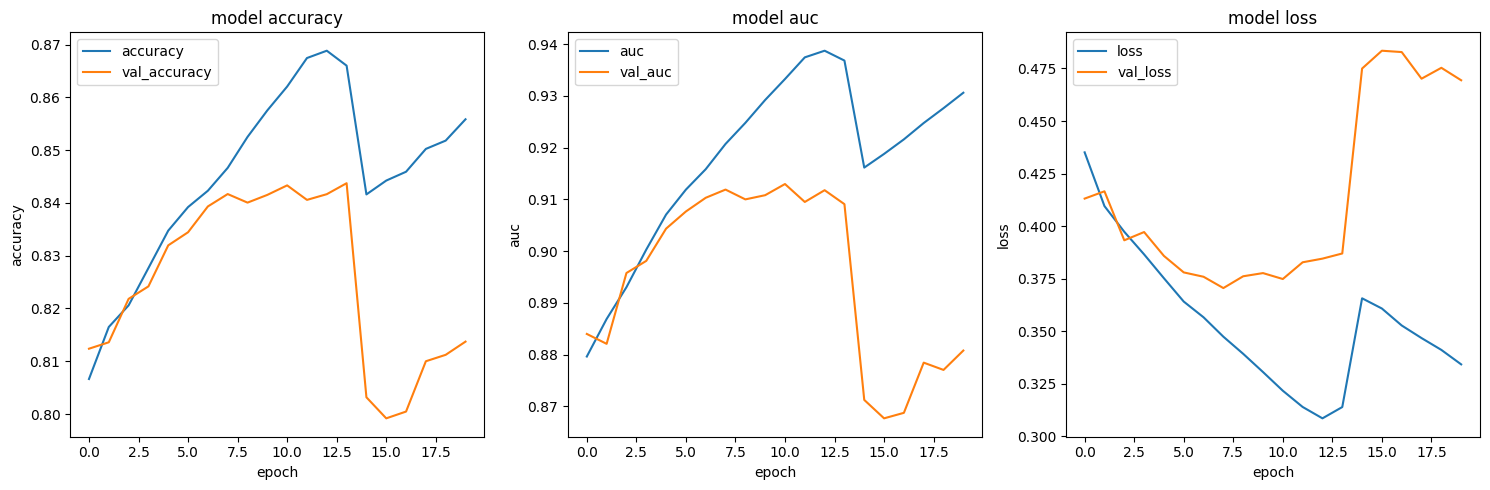

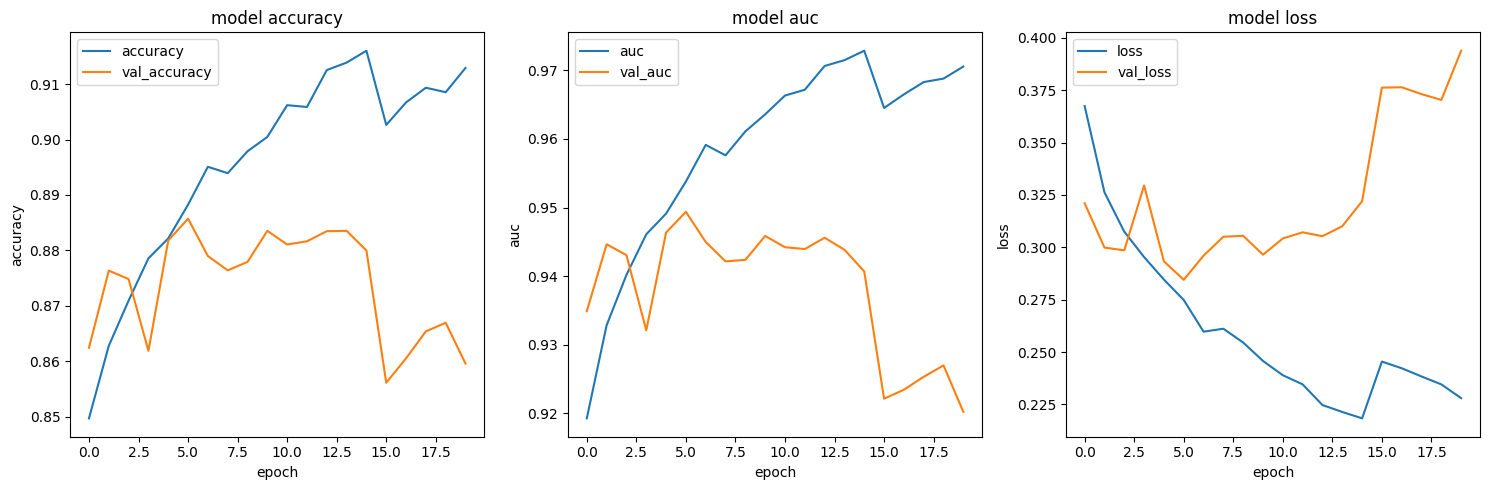

In [17]:
import matplotlib.pyplot as plt

for i, _ in enumerate(mean_history):
  # Create a figure with two subplots side by side
  fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(15, 5))

  # plt.plot(m.history['loss'])
  plt1.plot(mean_history[i][0])
  plt1.plot(mean_history[i][1])
  plt1.set_title('model accuracy')
  plt1.set_ylabel('accuracy')
  plt1.set_xlabel('epoch')
  plt1.legend(['accuracy', 'val_accuracy'], loc='upper left')

  # plt.plot(m.history['loss'])
  plt2.plot(mean_history[i][2])
  plt2.plot(mean_history[i][3])
  plt2.set_title('model auc')
  plt2.set_ylabel('auc')
  plt2.set_xlabel('epoch')
  plt2.legend(['auc', 'val_auc'], loc='upper left')

  # plt.plot(m.history['loss'])
  plt3.plot(mean_history[i][4])
  plt3.plot(mean_history[i][5])
  plt3.set_title('model loss')
  plt3.set_ylabel('loss')
  plt3.set_xlabel('epoch')
  plt3.legend(['loss', 'val_loss'], loc='upper left')

  plt.tight_layout()
  plt.show()

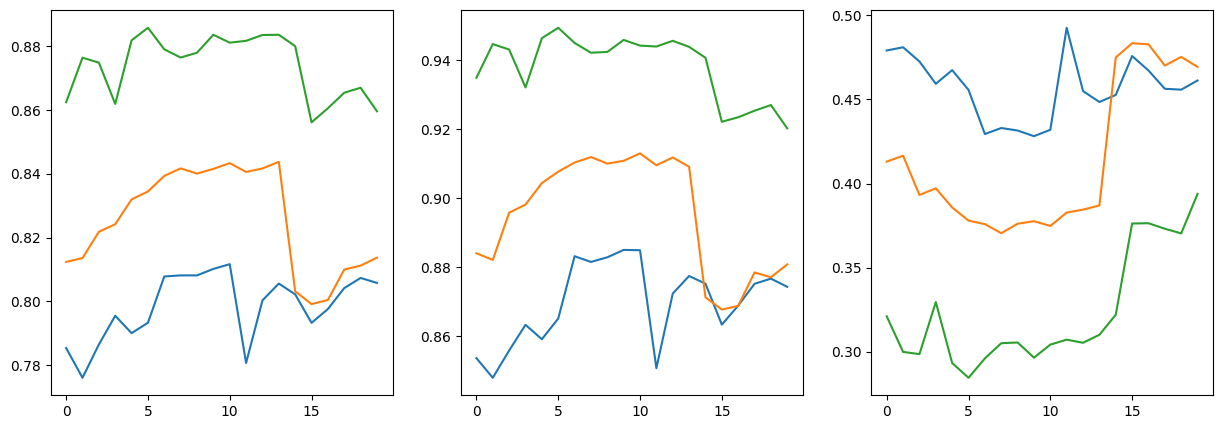

In [18]:
fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(15, 5))
plts = [plt1, plt2, plt3]

for i, chart in enumerate(range(0, 5, 2)):
  plts[i].plot(mean_history[0][chart+1])
  plts[i].plot(mean_history[1][chart+1])
  plts[i].plot(mean_history[2][chart+1])
  # plts[i].legend([f"lstm softmax val_acc", f"lstm sigmoid val_auc", f"gru softmax val_loss", f"gru sigmoid {chart_type}"], loc="lower right")

Inference:
Inference:
Inference:
289/289 [==============================] - 1s 2ms/step


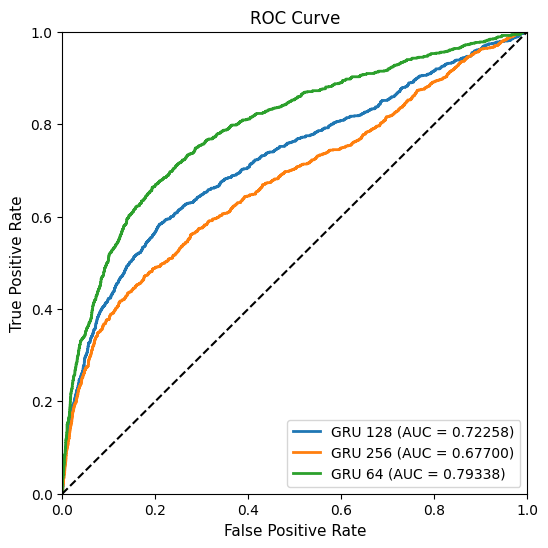

,Model,Balanced acc Train,Balanced acc Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
0,GRU 128,0.883452,0.672001,0.531187,0.302682,0.858256,0.476382,0.656226,0.370168
1,GRU 256,0.929640,0.640839,0.684828,0.298701,0.909776,0.392965,0.781436,0.339410
2,GRU 64,0.828979,0.729575,0.390530,0.309559,0.810505,0.628141,0.527090,0.414731


In [19]:
from keras.models import load_model
reload(me)

trained_models = {}
model_names = ['GRU 128', 'GRU 256', 'GRU 64']
for i, m in enumerate(model_names):
  print("Inference:")
  model = load_model(f"models/weights_best_struct_gru1_{i}.hdf5")
  model.optimizer.lr.numpy()
  trained_models[m] = model

me.plot_combined_roc_curves(trained_models, x_train, y_train, x_test, y_test)
# me.print_results(model, x_train, y_train, x_test, y_test)